In [13]:
import torch
print(torch.cuda.is_available())

True


### 코드 해석과 함수 동작 원리

#### 필요한 모듈 임포트
```python
import os  # 운영체제 관련 기능을 사용하기 위해 임포트함
import json  # JSON 파일을 읽고 쓰기 위해 임포트함
import torch  # PyTorch 라이브러리를 임포트함
import torch.nn as nn  # 신경망 관련 모듈을 임포트함
from torchvision import transforms, models  # torchvision의 변환 및 모델 관련 기능을 임포트함
from torch.utils.data import DataLoader, Dataset  # 데이터 로딩 및 커스텀 데이터셋 관련 기능을 임포트함
from PIL import Image  # 이미지 처리를 위해 PIL 라이브러리를 임포트함
from tqdm import tqdm  # 진행 상황을 시각적으로 보여주기 위해 tqdm를 임포트함
from sklearn.metrics import f1_score  # F1 점수를 계산하기 위해 scikit-learn의 f1_score 함수를 임포트함
```

#### Google Colab의 GPU 사용 설정
```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 사용 가능하면 GPU를 사용하고, 그렇지 않으면 CPU를 사용함
print(f'Using device: {device}')  # 사용 중인 디바이스를 출력함
```

#### NVIDIA GPU 종류 확인
```python
!nvidia-smi  # NVIDIA GPU 정보를 출력하는 명령어를 실행함
```

#### CustomDataset 클래스 정의
```python
class CustomDataset(Dataset):  # Dataset 클래스를 상속받아 CustomDataset을 정의함
    def __init__(self, src_base_folder, label_base_folder, transform=None):  # 초기화 메서드 정의
        self.src_base_folder = src_base_folder  # 원천 데이터 폴더 경로를 저장함
        self.label_base_folder = label_base_folder  # 라벨 데이터 폴더 경로를 저장함
        self.transform = transform  # 이미지 변환을 저장함

        self.image_paths = []  # 이미지 경로를 저장할 리스트 초기화
        self.labels = []  # 라벨을 저장할 리스트 초기화

        # src_base_folder 내의 모든 식물 폴더를 순회함
        for plant_folder in os.listdir(src_base_folder):
            if plant_folder.startswith("TS_"):  # 폴더 이름이 "TS_"로 시작하는 경우
                plant_type = plant_folder[3:]  # 식물 이름을 추출함
                label_plant_folder = f"TL_{plant_type}"  # 라벨 폴더 이름을 구성함
                parts_folders = os.listdir(os.path.join(src_base_folder, plant_folder))

                # 각 부위 폴더(꽃, 열매, 잎, 전초)를 순회함
                for part_folder in parts_folders:
                    src_folder = os.path.join(src_base_folder, plant_folder, part_folder)
                    label_folder = os.path.join(label_base_folder, label_plant_folder, part_folder)

                    # 이미지와 해당 JSON 파일을 매칭함
                    for image_name in os.listdir(src_folder):
                        if image_name.endswith('.jpg'):  # 이미지 파일인 경우
                            image_path = os.path.join(src_folder, image_name)
                            label_name = image_name.replace('.jpg', '.json')
                            label_path = os.path.join(label_folder, label_name)

                            if os.path.exists(label_path):  # 라벨 파일이 존재하는 경우
                                with open(label_path, 'r', encoding='utf-8') as file:  # 라벨 파일을 읽음
                                    data = json.load(file)
                                    toxic_info = data['plantinfo']['toxic_info']
                                    if toxic_info == 'Y':
                                        label = 1  # 독초
                                    else:
                                        label = 0  # 비독초

                                    self.image_paths.append(image_path)  # 이미지 경로를 리스트에 추가함
                                    self.labels.append(label)  # 라벨을 리스트에 추가함
                            else:
                                print(f'라벨 파일이 없습니다: {label_path}')
                        else:
                            print(f'이미지 파일이 없습니다: {image_path}')

        if len(self.image_paths) == 0 or len(self.labels) == 0:
            raise ValueError("데이터셋에 이미지나 라벨이 없습니다.")  # 데이터셋에 이미지나 라벨이 없으면 오류를 발생시킴

    def __len__(self):  # 데이터셋의 길이를 반환함
        return len(self.image_paths)

    def __getitem__(self, idx):  # 주어진 인덱스에 대한 이미지와 라벨을 반환함
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # 이미지를 열고 RGB로 변환함

        label = self.labels[idx]

        if self.transform:  # 변환이 정의되어 있으면 변환을 적용함
            image = self.transform(image)

        return image, label
```

### CustomDataset 클래스 동작 원리
- `__init__` 메서드는 데이터셋을 초기화하며, 원천 데이터와 라벨 데이터 폴더를 받아옴. 폴더 내의 이미지 파일과 JSON 파일을 매칭해 이미지 경로와 라벨을 리스트에 저장함.
- `__len__` 메서드는 데이터셋의 전체 길이를 반환함.
- `__getitem__` 메서드는 인덱스를 받아 해당 인덱스의 이미지와 라벨을 반환함. 이미지 변환이 정의되어 있으면 이를 적용함.

#### 이미지 전처리 변환 설정
```python
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지를 224x224 크기로 조정함
    transforms.ToTensor(),  # 이미지를 텐서로 변환함
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지를 정규화함
])
```

#### 데이터셋 경로 설정
```python
src_base_path = "180.동의보감 약초 이미지 AI데이터/01.데이터/1.Training/원천데이터"  # 원천 데이터 경로 설정함
label_base_path = "180.동의보감 약초 이미지 AI데이터/01.데이터/1.Training/라벨링데이터"  # 라벨 데이터 경로 설정함
```

#### 데이터셋 로딩
```python
full_dataset = CustomDataset(src_base_path, label_base_path, transform=transform)  # CustomDataset 인스턴스 생성함
```

#### 데이터셋 분할: 훈련 60%, 검증 20%, 테스트 20%
```python
train_size = int(0.6 * len(full_dataset))  # 훈련 데이터셋 크기 설정함
val_size = int(0.2 * len(full_dataset))  # 검증 데이터셋 크기 설정함
test_size = len(full_dataset) - train_size - val_size  # 테스트 데이터셋 크기 설정함
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])  # 데이터셋을 분할함
```

#### 데이터 로더 설정
```python
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 훈련 데이터 로더 설정함
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # 검증 데이터 로더 설정함
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # 테스트 데이터 로더 설정함
```

#### 모델 설정: ResNet50
```python
model = models.resnet50(pretrained=True)  # 사전 훈련된 ResNet50 모델 로드함
num_ftrs = model.fc.in_features  # 마지막 완전 연결 계층의 입력 피처 수 가져옴
model.fc = nn.Linear(num_ftrs, 2)  # 이진 분류를 위한 새로운 완전 연결 계층 설정함
model = model.to(device)  # 모델을 GPU로 이동함
```

#### 손실 함수와 최적화 함수 설정
```python
criterion = nn.CrossEntropyLoss()  # 손실 함수로 교차 엔트로피 손실 설정함
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # 최적화 함수로 SGD 설정함
```

#### 모델 훈련 함수
```python
def train_model(model, criterion, optimizer, num_epochs=10):  # 모델 훈련 함수 정의함
    best_acc = 0.0

    for epoch in range(num_epochs):  # 에포크 반복함
        model.train()  # 모델을 훈련 모드로 설정함
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader):  # 훈련 데이터 로더에서 미니 배치 반복함
            inputs = inputs.to(device)  # 입력 데이터를 GPU로 이동함
            labels = labels.to(device)  # 라벨 데이터를 GPU로 이동함

            optimizer.zero_grad()  # 옵티마이저의 기울기 초기화함

            outputs = model(inputs)  # 모델을 통해 예측값 생성함


            _, preds = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스 선택함
            loss = criterion(outputs, labels)  # 손실 계산함

            loss.backward()  # 역전파로 기울기 계산함
            optimizer.step()  # 옵티마이저로 가중치 갱신함

            running_loss += loss.item() * inputs.size(0)  # 손실값 누적함
            running_corrects += torch.sum(preds == labels.data)  # 정확도 계산함

        epoch_loss = running_loss / len(train_dataset)  # 에포크 당 손실 계산함
        epoch_acc = running_corrects.double() / len(train_dataset)  # 에포크 당 정확도 계산함

        print(f'Epoch {epoch+1}/{num_epochs} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        model.eval()  # 모델을 평가 모드로 설정함
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():  # 기울기 계산을 비활성화함
            for inputs, labels in tqdm(val_loader):  # 검증 데이터 로더에서 미니 배치 반복함
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

            val_loss = val_loss / len(val_dataset)  # 검증 손실 계산함
            val_acc = val_corrects.double() / len(val_dataset)  # 검증 정확도 계산함

            print(f'Epoch {epoch+1}/{num_epochs} Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

            if val_acc > best_acc:  # 최고 검증 정확도 갱신 시
                best_acc = val_acc
                best_model_wts = model.state_dict()
                torch.save(model.state_dict(), '김지훈/best_model_resnet50.pth')  # 모델 가중치 저장함

    print(f'Best Val Acc: {best_acc:.4f}')
    return model
```

### train_model 함수 동작 원리
- 모델을 훈련하고 검증함. 최적의 검증 정확도를 가진 모델의 가중치를 저장함.
- 에포크마다 모델을 훈련하고 손실과 정확도를 계산함.
- 검증 데이터를 사용해 모델을 평가하고, 최적의 검증 정확도를 갱신하면 모델 가중치를 저장함.

#### 모델 훈련
```python
trained_model = train_model(model, criterion, optimizer, num_epochs=10)  # 모델을 10 에포크 동안 훈련함
```

#### 테스트 세트에서 모델 성능 평가 및 F1 점수 계산
```python
def evaluate_model(model, test_loader):  # 모델 평가 함수 정의함
    model.eval()
    running_corrects = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # 기울기 계산을 비활성화함
        for inputs, labels in tqdm(test_loader):  # 테스트 데이터 로더에서 미니 배치 반복함
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = running_corrects.double() / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'F1 Score: {f1:.4f}')

evaluate_model(trained_model, test_loader)  # 모델 평가 실행함
```

### evaluate_model 함수 동작 원리
- 모델을 테스트 데이터셋에서 평가함. 정확도와 F1 점수를 계산함.
- 모든 배치의 예측 값과 실제 라벨을 수집해 성능 지표를 계산함.

#### 예측 함수 정의
```python
def predict_toxicity(model, image_path, transform):  # 독성 예측 함수 정의함
    model.eval()
    image = Image.open(image_path).convert('RGB')  # 이미지를 열고 RGB로 변환함
    image = transform(image).unsqueeze(0).to(device)  # 이미지를 변환하고 배치 차원을 추가하여 GPU로 이동함

    with torch.no_grad():  # 기울기 계산을 비활성화함
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        probability = torch.nn.functional.softmax(outputs, dim=1)[0][preds[0]]

    class_names = ['비독초', '독초']
    return class_names[preds[0]], probability.item()  # 예측 클래스와 확률 반환함
```

### predict_toxicity 함수 동작 원리
- 주어진 이미지 파일 경로에 대해 독성 여부를 예측함.
- 이미지를 변환하고 모델을 통해 예측 결과를 얻음. 예측된 클래스와 그 확률을 반환함.

#### 예측을 위한 예시 이미지 경로 설정
```python
example_image_path = '김지훈/참취.jpeg'  # 예시 이미지 경로 설정함
```

#### 이미지에 대한 예측 및 결과 출력
```python
predicted_class, probability = predict_toxicity(trained_model, example_image_path, transform)  # 이미지에 대한 예측 수행함
print(f'이 식물은 {predicted_class}입니다. 예측 확률은 {probability:.4f}입니다.')  # 예측 결과 출력함
```

Using device: cuda
Tue May 28 17:16:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8              12W / 180W |   4385MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

  2%|█▋                                                                                | 4/196 [00:40<33:12, 10.38s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [33:53<00:00, 10.37s/it]


Epoch 1/10 Train Loss: 0.4150 Acc: 0.8090 F1: 0.8033


  3%|██▌                                                                                | 2/65 [00:16<08:41,  8.27s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [09:01<00:00,  8.33s/it]


Epoch 1/10 Val Loss: 0.2331 Acc: 0.9038 F1: 0.9044


  4%|███▎                                                                              | 8/196 [01:17<30:05,  9.60s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [32:41<00:00, 10.01s/it]


Epoch 2/10 Train Loss: 0.1292 Acc: 0.9494 F1: 0.9493


  3%|██▌                                                                                | 2/65 [00:17<08:56,  8.51s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [09:05<00:00,  8.40s/it]


Epoch 2/10 Val Loss: 0.1969 Acc: 0.9178 F1: 0.9190


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [30:51<00:00,  9.45s/it]


Epoch 3/10 Train Loss: 0.0465 Acc: 0.9859 F1: 0.9859


  3%|██▌                                                                                | 2/65 [00:16<08:54,  8.49s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [09:07<00:00,  8.43s/it]


Epoch 3/10 Val Loss: 0.1599 Acc: 0.9399 F1: 0.9404


  1%|▍                                                                                 | 1/196 [00:09<30:47,  9.48s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [30:01<00:00,  9.19s/it]


Epoch 4/10 Train Loss: 0.0403 Acc: 0.9861 F1: 0.9861


  3%|██▌                                                                                | 2/65 [00:16<08:25,  8.02s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [08:41<00:00,  8.03s/it]


Epoch 4/10 Val Loss: 0.1603 Acc: 0.9505 F1: 0.9507


  1%|▊                                                                                 | 2/196 [00:17<28:29,  8.81s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [31:05<00:00,  9.52s/it]


Epoch 5/10 Train Loss: 0.0190 Acc: 0.9950 F1: 0.9950


  3%|██▌                                                                                | 2/65 [00:15<08:15,  7.87s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [08:38<00:00,  7.97s/it]


Epoch 5/10 Val Loss: 0.1639 Acc: 0.9490 F1: 0.9494


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [30:52<00:00,  9.45s/it]


Epoch 6/10 Train Loss: 0.0076 Acc: 0.9982 F1: 0.9982


  3%|██▌                                                                                | 2/65 [00:16<08:32,  8.14s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [08:44<00:00,  8.07s/it]


Epoch 6/10 Val Loss: 0.1328 Acc: 0.9553 F1: 0.9552


  2%|█▋                                                                                | 4/196 [00:34<27:51,  8.71s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [30:01<00:00,  9.19s/it]


Epoch 7/10 Train Loss: 0.0064 Acc: 0.9986 F1: 0.9986


  3%|██▌                                                                                | 2/65 [00:16<08:28,  8.06s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [08:48<00:00,  8.13s/it]


Epoch 7/10 Val Loss: 0.1837 Acc: 0.9519 F1: 0.9523


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [29:56<00:00,  9.17s/it]


Epoch 8/10 Train Loss: 0.0061 Acc: 0.9986 F1: 0.9986


  3%|██▌                                                                                | 2/65 [00:15<08:19,  7.94s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [08:41<00:00,  8.02s/it]


Epoch 8/10 Val Loss: 0.1374 Acc: 0.9567 F1: 0.9567


  1%|▊                                                                                 | 2/196 [00:17<28:47,  8.90s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [29:51<00:00,  9.14s/it]


Epoch 9/10 Train Loss: 0.0059 Acc: 0.9982 F1: 0.9982


  3%|██▌                                                                                | 2/65 [00:16<08:27,  8.06s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [08:45<00:00,  8.08s/it]


Epoch 9/10 Val Loss: 0.1475 Acc: 0.9567 F1: 0.9569


  2%|█▋                                                                                | 4/196 [00:32<25:55,  8.10s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [29:54<00:00,  9.15s/it]


Epoch 10/10 Train Loss: 0.0035 Acc: 0.9992 F1: 0.9992


  3%|██▌                                                                                | 2/65 [00:16<08:31,  8.12s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [08:42<00:00,  8.04s/it]


Epoch 10/10 Val Loss: 0.1588 Acc: 0.9567 F1: 0.9568
Best Val Acc: 0.9567


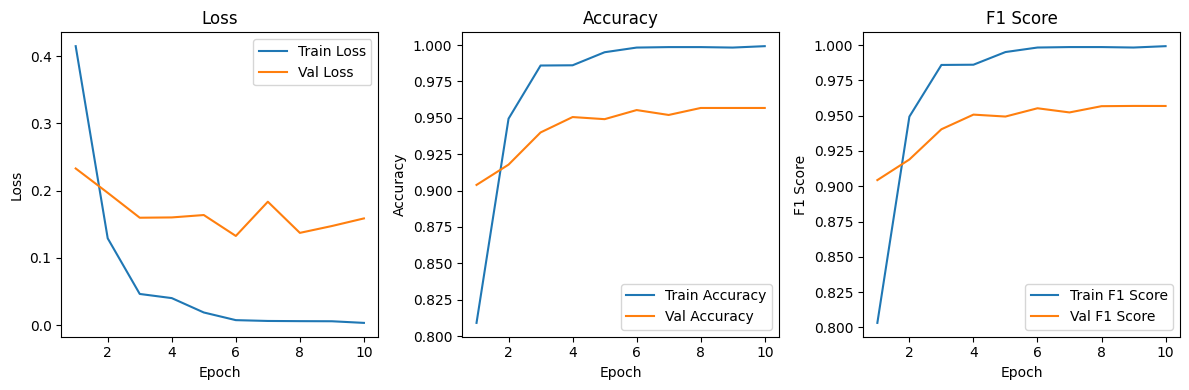

  2%|█▎                                                                                 | 1/66 [00:07<07:45,  7.16s/it]C:\Users\MNL431\Anaconda3\envs\poisonous\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [08:57<00:00,  8.15s/it]

Test Accuracy: 0.9635
F1 Score: 0.9634
이 식물은 독초입니다. 예측 확률은 0.9800입니다.


In [14]:
# 필요한 모듈 임포트
import os
import json
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Google Colab의 GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# NVIDIA GPU 종류 확인
!nvidia-smi

# CustomDataset 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, src_base_folder, label_base_folder, transform=None):
        self.src_base_folder = src_base_folder
        self.label_base_folder = label_base_folder
        self.transform = transform

        self.image_paths = []
        self.labels = []

        # src_base_folder 내의 모든 식물 폴더를 순회함
        for plant_folder in os.listdir(src_base_folder):
            if plant_folder.startswith("VS_"):
                plant_type = plant_folder[3:]  # 식물 이름
                label_plant_folder = f"VL_{plant_type}"  # 라벨 폴더 이름
                parts_folders = os.listdir(os.path.join(src_base_folder, plant_folder))

                # 각 부위 폴더(꽃, 열매, 잎, 전초)를 순회함
                for part_folder in parts_folders:
                    src_folder = os.path.join(src_base_folder, plant_folder, part_folder)
                    label_folder = os.path.join(label_base_folder, label_plant_folder, part_folder)

                    # 이미지와 해당 JSON 파일을 매칭함
                    for image_name in os.listdir(src_folder):
                        if image_name.endswith('.jpg'):
                            image_path = os.path.join(src_folder, image_name)
                            label_name = image_name.replace('.jpg', '.json')
                            label_path = os.path.join(label_folder, label_name)

                            if os.path.exists(label_path):
                                with open(label_path, 'r', encoding='utf-8') as file:  # 인코딩 추가
                                    data = json.load(file)
                                    toxic_info = data['plantinfo']['toxic_info']
                                    if toxic_info == 'Y':
                                        label = 1  # 독초
                                    else:
                                        label = 0  # 비독초

                                    self.image_paths.append(image_path)
                                    self.labels.append(label)
                            else:
                                print(f'라벨 파일이 없습니다: {label_path}')
                        else:
                            image_path = os.path.join(src_folder, image_name)
                            print(f'이미지 파일이 없습니다: {image_path}')

        if len(self.image_paths) == 0 or len(self.labels) == 0:
            raise ValueError("데이터셋에 이미지나 라벨이 없습니다.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 이미지 전처리 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 경로 설정
src_base_path = "180.동의보감 약초 이미지 AI데이터/01.데이터/2.Validation/원천데이터"
label_base_path = "180.동의보감 약초 이미지 AI데이터/01.데이터/2.Validation/라벨링데이터"

# 데이터셋 로딩
full_dataset = CustomDataset(src_base_path, label_base_path, transform=transform)

# 데이터셋 분할: 훈련 60%, 검증 20%, 테스트 20%
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# seed 값을 지정해서 같은 데이터셋에 대해 모델 성능 평가
generator2 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size], generator=generator2)

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 설정: ResNet50
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 이진 분류
model = model.to(device)

# 손실 함수와 최적화 함수 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 모델 훈련 함수
def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1_scores, val_f1_scores = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        all_train_preds = []
        all_train_labels = []

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        epoch_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        train_f1_scores.append(epoch_f1)

        print(f'Epoch {epoch+1}/{num_epochs} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

            val_loss = val_loss / len(val_dataset)
            val_acc = val_corrects.double() / len(val_dataset)
            val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

            val_losses.append(val_loss)
            val_accuracies.append(val_acc.item())
            val_f1_scores.append(val_f1)

            print(f'Epoch {epoch+1}/{num_epochs} Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}')

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
                torch.save(model.state_dict(), 'best_model_resnet50.pth')

    print(f'Best Val Acc: {best_acc:.4f}')

    # 그래프 그리기
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1_scores, label='Train F1 Score')
    plt.plot(epochs, val_f1_scores, label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# 모델 훈련
trained_model = train_model(model, criterion, optimizer, num_epochs=10)

# 테스트 세트에서 모델 성능 평가 및 F1 점수 계산
def evaluate_model(model, test_loader):
    model.eval()
    running_corrects = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = running_corrects.double() / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'F1 Score: {f1:.4f}')

evaluate_model(trained_model, test_loader)

# 예측 함수 정의
def predict_toxicity(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        probability = torch.nn.functional.softmax(outputs, dim=1)[0][preds[0]]

    class_names = ['비독초', '독초']
    return class_names[preds[0]], probability.item()

# 예측을 위한 예시 이미지 경로 설정 (사용자 환경에 맞게 설정해야 함)
example_image_path = '김지훈/참취.jpeg'

# 이미지에 대한 예측 및 결과 출력
predicted_class, probability = predict_toxicity(trained_model, example_image_path, transform)
print(f'이 식물은 {predicted_class}입니다. 예측 확률은 {probability:.4f}입니다.')

1. PyTorch
설명: PyTorch는 Python 기반의 과학 컴퓨팅 패키지로, 주로 딥러닝 연구와 개발에 사용됨. 동적 계산 그래프와 쉬운 API로 인해 인기가 많음.
내용: 텐서(Tensors): PyTorch의 핵심 데이터 구조로, 다차원 배열임.
자동 미분(Automatic Differentiation): 모델 학습을 위해 역전파 알고리즘을 자동으로 수행하는 기능.
모듈화된 신경망 설계: nn.Module 클래스를 사용하여 신경망 모듈을 정의하고 조립할 수 있음.
GPU 지원: CUDA를 사용하여 GPU 가속을 지원함.

2. torchvision
설명: PyTorch 생태계의 일부로, 컴퓨터 비전 관련 데이터셋, 모델 아키텍처, 이미지 변환 유틸리티를 제공함.
내용:
데이터셋(Datasets): 다양한 공개 데이터셋을 쉽게 로드할 수 있음.
모델(Model Zoo): 사전 훈련된 다양한 모델 아키텍처를 제공함.
변환(Transformations): 이미지 전처리를 위한 다양한 변환 함수 제공.

3. Google Colab
설명: Google에서 제공하는 클라우드 기반의 Jupyter 노트북 환경으로, 무료로 GPU를 사용할 수 있음.
내용:
무료 GPU 사용: 제한된 시간 동안 무료로 GPU를 사용할 수 있음.
협업 기능: 여러 사용자가 동시에 노트북을 편집하고 실행할 수 있음.
구글 드라이브 연동: 쉽게 데이터를 업로드하고 접근할 수 있음.

4. CUDA
설명: NVIDIA에서 제공하는 병렬 컴퓨팅 플랫폼으로, GPU를 활용하여 계산을 가속화함.
내용:
병렬 처리: 다수의 연산을 동시에 처리하여 성능을 극대화함.
PyTorch 연동: PyTorch에서 CUDA를 사용하여 텐서 연산을 GPU에서 수행함.

5. ResNet50 모델
설명: 딥러닝 이미지 분류 모델 중 하나로, 잔차 학습(Residual Learning)을 통해 매우 깊은 네트워크도 효과적으로 학습할 수 있음.
내용:
잔차 블록(Residual Blocks): 입력을 다음 층으로 직접 연결하여 기울기 소실 문제를 해결함.
사전 훈련 모델: ImageNet 데이터셋으로 미리 학습된 모델을 제공하여 빠르게 전이 학습을 할 수 있음.

6. 데이터 전처리
설명: 모델 학습 전에 데이터를 정리하고 변환하는 과정임.
내용:
이미지 크기 조정: 모든 이미지를 동일한 크기로 변환함.
텐서 변환: 이미지를 텐서 형식으로 변환함.
정규화(Normalization): 이미지 픽셀 값을 정규화하여 모델 학습을 안정화함.

7. 데이터 로더
설명: 데이터셋을 배치 단위로 로드하고, 모델 학습에 필요한 데이터를 제공하는 역할을 함.
내용:
배치 처리: 데이터를 배치 단위로 나누어 효율적으로 학습할 수 있도록 함.
셔플(Shuffle): 학습 시 데이터 순서를 무작위로 섞어 학습의 다양성을 높임.

8. Custom Dataset 클래스
설명: PyTorch의 Dataset 클래스를 상속받아 사용자 정의 데이터셋을 생성할 수 있음.
내용:
데이터 경로 설정: 원천 데이터와 라벨 데이터 경로를 설정함.
이미지와 라벨 매핑: 이미지 파일과 JSON 라벨 파일을 매핑하여 데이터셋을 구성함.
데이터 반환: 지정된 인덱스의 이미지와 라벨을 반환함.

9. 모델 훈련 (Training)
설명: 모델을 데이터에 맞게 최적화하는 과정임.
내용:
역전파(Backpropagation): 손실 함수의 기울기를 계산하여 모델의 가중치를 업데이트함.
에포크(Epoch): 전체 데이터셋을 한 번 학습하는 과정을 반복함.
손실 값 계산: 모델의 예측값과 실제 값 사이의 손실을 계산함.

10. 모델 평가 (Evaluation)
설명: 훈련된 모델의 성능을 검증하는 과정임.
내용:
검증 데이터셋 사용: 학습에 사용되지 않은 데이터를 사용하여 모델의 일반화 성능을 평가함.
정확도 계산: 모델의 예측값이 실제 값과 일치하는 비율을 계산함.

11. 손실 함수 (Loss Function)
설명: 모델의 예측값과 실제 값 사이의 차이를 계산하는 함수임.
내용:
교차 엔트로피 손실(Cross-Entropy Loss): 분류 문제에서 주로 사용하는 손실 함수임.

12. 최적화 함수 (Optimizer)
설명: 손실 함수를 최소화하기 위해 모델의 가중치를 조정하는 알고리즘임.
내용:
SGD(Stochastic Gradient Descent): 확률적 경사 하강법을 사용하여 모델을 최적화함.
모멘텀(Momentum): SGD에 모멘텀을 추가하여 학습 속도를 가속화함.

13. F1 Score 계산
설명: 모델의 성능을 평가하기 위해 정밀도(Precision)와 재현율(Recall)을 조합한 점수임.
내용:
정밀도(Precision): 모델이 True Positive로 예측한 샘플의 비율임.
재현율(Recall): 실제 True Positive 샘플 중 모델이 True Positive로 예측한 비율임.
F1 Score: 정밀도와 재현율의 조화 평균임.

14. JSON 데이터 처리
설명: JSON 형식의 라벨 파일을 읽고 필요한 정보를 추출함.
내용:
JSON 파싱: JSON 파일을 파싱하여 데이터 구조로 변환함.
라벨 추출: 파싱된 JSON 데이터에서 독성 여부를 추출함.

15. 이미지 변환 및 정규화 (Transformations and Normalization)
설명: 이미지 데이터를 모델에 입력하기 전에 변환하고 정규화하는 과정임.
내용:
크기 조정(Resize): 이미지를 모델 입력 크기에 맞게 조정함.
텐서 변환(ToTensor): 이미지를 텐서 형식으로 변환함.
정규화(Normalize): 이미지의 픽셀 값을 일정 범위로 정규화함.

16. 모델 저장 및 로드
설명: 훈련된 모델의 가중치를 저장하고 필요할 때 로드함.
내용:
모델 저장(Save): 최적의 모델 가중치를 파일로 저장함.
모델 로드(Load): 저장된 모델 가중치를 불러와 모델에 적용함.

17. 예측 함수 (Prediction Function)
설명: 학습된 모델을 사용하여 새로운 데이터에 대한 예측을 수행함.
내용:
이미지 로드 및 변환: 입력 이미지를 로드하고 변환함.
모델 예측: 변환된 이미지를 모델에 입력하여 예측 결과를 얻음.
예측 결과 반환: 예측된 클래스와 확률을 반환함.

18. tqdm (진행률 표시)
설명: 반복 작업의 진행 상황을 시각적으로 표시함.
내용:
진행 바 표시: 학습 및 평가 과정에서 진행 상황을 표시하여 사용자가 현재 상태를 쉽게 파악할 수 있도록 함.

In [19]:

example_image_path = '김지훈/참취.jpeg'

# 이미지에 대한 예측 및 결과 출력
predicted_class, probability = predict_toxicity(trained_model, example_image_path, transform)
print(f'이 식물은 {predicted_class}입니다. 예측 확률은 {probability:.4f}입니다.')

이 식물은 독초입니다. 예측 확률은 0.9800입니다.
